# Data Analysis Project Report


# Introduction

__Problem:__ Public Hospitals are overwhelmed by the high number of patient admissions and emergency admissions. The goal is to predict the number of emergency admissions in the upcoming months, to help prevent bed shortage and focus resources on the hospital departments that are the most in need. 

The objectives of this project is to:
    
__Objectif 1:__ Using the information about the number of emergency admissions in the past months, forecast the number of emergency admissions in the upcoming months. 

__Objectif 2:__ Using the information about the number of emergency admissions depending on the Treatment speciality, identify which hospital departments are most likely to receive a high number of emergency admissions in the upcoming months. 

# Dataset

The dataset used in this project is the __Hospital Episodes Statistics (HES) dataset__, it consists of the record of all patients admitted to NHS (public) hospitals in England. It contains details of inpatient care such as number of admissions and number of emergency admissions, and it also contains details of outpatient appointments such as attended appointments and missed appointments. 

The records are filtered by treatment speciality, and they are produced and published monthly. The version used in this project covers the period from April 30 2018 to August 31 2021. 

In our case, we will just use the date (__"Month_Ending"__) and the treatment speciality type (__"TRETSPEF"__) to predict the number of emergency admissions (__"EMERGENCY"__) in the future. Therefore all the columns that are in the dataset and not needed are dropped. 

The dataset can be downloaded from the [NHS Digital website](https://digital.nhs.uk/data-and-information/publications/statistical/hospital-episode-statistics-for-admitted-patient-care-outpatient-and-accident-and-emergency-data/april-2021---september-2021) 

# Import / Install Packages 

First we need to install and import the needed packages for this project. 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
#from keras.layers import Convolution1D
#from tensorflow.keras.layers import BatchNormalization
#from tensorflow.keras.layers import MaxPooling1D

#display all rows
#pd.set_option('display.max_rows', None)

# Load the data

The columns that are not needed in this project have already been dropped, and the remaining columns where save as a new csv file (__Emergency_only.csv__)

In [2]:
#Load the dataset
df_TRETSPEF = pd.read_csv('/Users/chaima/Documents/DA_Project/Emergency_only.csv')
print(df_TRETSPEF.head(5))
df_TRETSPEF.shape

  Month_Ending  TRETSPEF  EMERGENCY
0   2021-08-31       100    49715.0
1   2021-08-31       101    11857.0
2   2021-08-31       102      289.0
3   2021-08-31       103       93.0
4   2021-08-31       104     3901.0


(6329, 3)

In [3]:
#check data types 
df_TRETSPEF.dtypes

Month_Ending     object
TRETSPEF          int64
EMERGENCY       float64
dtype: object

# Preprocess the data

A big part of this project's work is to preprocess data so that it can be fed to the LSTM model later.

First we remove the rows where the treatment speciality is unkown

In [4]:
#drop rows where the treatment type is unkown 
df_TRETSPEF = df_TRETSPEF[df_TRETSPEF.TRETSPEF != '&']

The "Month_Ending" column which has type object, it needs to be converted to datetime so that it can be fed to the LSTM.

In [5]:
#convert the Month_Ending from float to datetime
df_TRETSPEF['Month_Ending'] = pd.to_datetime(df_TRETSPEF.Month_Ending , format = '%Y-%m-%d')
data = df_TRETSPEF.drop(['Month_Ending'], axis=1)
data.index = df_TRETSPEF.Month_Ending

In [6]:
#check types 
df_TRETSPEF.dtypes

Month_Ending    datetime64[ns]
TRETSPEF                 int64
EMERGENCY              float64
dtype: object

## Normalize the data

We need the data's values to be on the same scale before being input to the model. 

We use the scikit-learn object __MinMaxScaler__ to normalize the dataset. the advantages of using MinMaxScaler are: 
1. Fit the scaler using available training data and then apply it the training data, meaning the training data will be used to estimate the minimum and macimum observable values, and then the normalized data is used to train the model. this is done by calling the function __fit_transform()__
2. Apply the scale to data going forward. This means you can prepare new data in the future on which you want to make predictions.

In [7]:
#Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_TRETSPEF.drop(columns=['Month_Ending','TRETSPEF']))
# create datefrane fir scaled data
scaled_df=pd.DataFrame(data=scaled,columns=df_TRETSPEF.drop(columns=['Month_Ending','TRETSPEF']).columns)

In [8]:
df=df_TRETSPEF.copy()
df[scaled_df.columns]=np.array(scaled_df)
df['TRETSPEF']=list(df.TRETSPEF)

## Handle the missing values

We need to first check if our dataset contains missing values:

In [9]:
#check is there are null values in the data
print(df.isnull().sum())

Month_Ending      0
TRETSPEF          0
EMERGENCY       409
dtype: int64


We can see that the __EMERGENCY__ column contains 409 missing values. We need to take care of these missing values, we can either:

1. Omit the entire row that contains the missing values: this will not be applied in this project, because it will make the dataset smaller. 
2. Impute or Interpolate the missing values: time series data is different then regular data because it depends on time. Therefore we cannot use the mean or median to fill out the missing values. Some of the most famous methods to handle missing data in time series are:
        - Last observation carried forward (LOCF)
        - Next observation carried backward (NOCB)
        - Linear interpolation 
        - Spline interpolation
        
In this project we use Pandas __interpolate()__ function to perform __Linear interpolation__ and fill out missing values. 

One important thing to do is to first reorder the data by Treatment speciality and by data. This is to ensure that the values obtained from interpolation are similar to the values of each treatment speciality (and not interpolated from other treatment specialities).

In [10]:
def interpolate_data(df):
    #interpolate data to handle missing data
    order_df = df.sort_values(['TRETSPEF', 'Month_Ending'], ascending=[True, False])
    interpolate_df = order_df.interpolate()
    interpolate_df = interpolate_df.sort_values(['Month_Ending'], ascending=[False])
    return interpolate_df

In [11]:
df=interpolate_data(df)

In [13]:
df=df.set_index(['Month_Ending'])
df.head(5)

,TRETSPEF,EMERGENCY
Month_Ending,,
2021-08-31,100,0.227734
2021-08-31,350,0.004691
2021-08-31,370,0.014938
2021-08-31,211,0.000495
2021-08-31,361,0.014439


In [12]:
#check if there are still NaN values 
print(df.isnull().sum())

Month_Ending    0
TRETSPEF        0
EMERGENCY       0
dtype: int64


# Split the data into training set and test set

To fit and evaluate the model, we need to split it into a training and test set. 

The problem with our dataset is that the data is not only time series data, it is considered __panel data__

__Panel Data__ (also known as __Longitudinal data__) is the data which tracks the same units at different time points.
In this case the units are the treatment specialities. 

Panel data cannot be split randomly like we would normaly do with regular cross-sectional data. Panel data needs to be split depending on each unit first, then the obtained splits are combined in to the final training set and test set. 
It is also important to take time in consideration when splitting the data, since we want to predict the future values, we want the training set to contain older samples, and the test set to contains the most recent samples (most recent values in time). 


In [14]:
#split data
def train_test_split(data):
    #data needs to be in ascending order so recent values are in test data 
    data = data.sort_values(['TRETSPEF', 'Month_Ending'], ascending=[True, True])
    size=int(len(data)*0.8)
    # for train data will be collected from each treatment's data which index is from 0-size (80%)
    x_train =data.drop(columns=['EMERGENCY']).iloc[0:size] 
    # for test data will be collected from each treatment's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['EMERGENCY']).iloc[size:]
    y_train=data['EMERGENCY'].iloc[0:size] 
    y_test=data['EMERGENCY'].iloc[size:] 
    return x_train, x_test,y_train,y_test

def train_test(data):
    # unique TRETSPEF
    TRSPEF=list(set(data.TRETSPEF))
    # loop each tretspef and split the data into train and test data
    X_train=[]
    X_test=[]
    Y_train=[]
    Y_test=[]
    for i in range(0,len(TRSPEF)):
        df=data[data['TRETSPEF']== TRSPEF[i]]
    # applied the function I created above
        x_train, x_test,y_train,y_test=train_test_split(df)
        X_train.append(x_train)
        X_test.append(x_test)
        Y_train.append(y_train)
        Y_test.append(y_test)
    # concatenate each train data n X_train list and Y_train list respectively
    X_train=pd.concat(X_train)
    Y_train=pd.DataFrame(pd.concat(Y_train))
    # concatenate each test dataset in X_test list and Y_test list respectively
    X_test=pd.concat(X_test)
    Y_test=pd.DataFrame(pd.concat(Y_test))
    return X_train, Y_train, X_test, Y_test


In [15]:
#split data
X_train, Y_train, X_test, Y_test = train_test(df)
#check the sets shape
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(4935, 1)
(4935, 1)
(1394, 1)
(1394, 1)


# Format the data

Before feeding our data to the model, it must be re-framed as supervised learning problems. From a sequence to pairs of input and output sequences.

this is necessary because we want to use old(t-1) data to predict the future(t+1). This is called the lag time. 


In [16]:
#Lag timestamp 
#transform the time series to a supervised learning problem 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    data = data.sort_values(['TRETSPEF', 'Month_Ending'], ascending=[False, True])
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
  
    return agg

# Reshape the data 

LSTMs take inputs in a 3D format: samples, timesteps, features. We need to reshape our data in the format expected by LSTMs. 

In [17]:
#Reshape data for LSTM
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)
    # split into train and test sets
    train= reframed_train.to_numpy()
    test=reframed_test.to_numpy()
    
    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test

In [18]:
#combine X train and Y train as train data 
train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
#combine X test and Y test as test data 
test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
# using the function to obtian reshaped x_train,x_test,y_train,y_test
x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)

In [19]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4934, 1, 3)
(4934,)
(1393, 1, 3)
(1393,)


# Implement the LSTM model

Choosing the architecture of our model is a key part of modelling.

We built an LSTM model with an LSTM layer containing 200 internal units. Followed by a Dense layer of 100 units and a dense layer with train_y.shape[0] units. The loss is computed using __mse__ and the optimizer used is the __adam__ optimizer.

The number of epochs is 15, and the batch_size is 30

In [20]:

def build_model(train_x, train_y, n_input=1):
    # define parameters
    verbose, epochs, batch_size = 1, 15, 30
    n_timesteps, n_features, n_outputs = train_x.shape[0], train_x.shape[1], train_y.shape[0]
   
    # define model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(200, activation='relu'))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(n_outputs))
    #model.compile(loss='mse', optimizer='adam',metrics=['mean_squared_error'])
    model.compile(loss='mse', optimizer='adam')
    
    # fit the model
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=False)
 
    return history, model

# Train the model

In [21]:
history, model = build_model(x_train, y_train, n_input=1)

Epoch 1/15
165/165 [==============================] - 2s 3ms/step - loss: 0.1919
Epoch 2/15
165/165 [==============================] - 1s 3ms/step - loss: 0.0072
Epoch 3/15
165/165 [==============================] - 1s 3ms/step - loss: 0.0071
Epoch 4/15
165/165 [==============================] - 1s 3ms/step - loss: 0.0070
Epoch 5/15
165/165 [==============================] - 1s 3ms/step - loss: 0.0067
Epoch 6/15
165/165 [==============================] - 1s 3ms/step - loss: 0.0065
Epoch 7/15
165/165 [==============================] - 1s 3ms/step - loss: 0.0065
Epoch 8/15
165/165 [==============================] - 1s 3ms/step - loss: 0.0065
Epoch 9/15
165/165 [==============================] - 1s 3ms/step - loss: 0.0065
Epoch 10/15
165/165 [==============================] - 1s 3ms/step - loss: 0.0065
Epoch 11/15
165/165 [==============================] - 1s 3ms/step - loss: 0.0065
Epoch 12/15
165/165 [==============================] - 1s 3ms/step - loss: 0.0065
Epoch 13/15
165/165 [====

# Plot the loss
The loss is decreasing over iterations

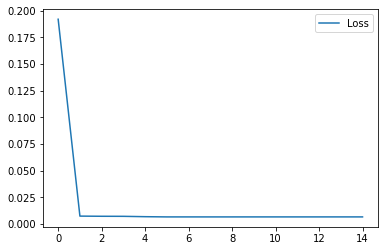

In [23]:
# plot the loss
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

# Make predictions

Now that we have a model, we would like to be able to make predictions.

In [24]:
# make a prediction
y_test_pre=model.predict(x_test)
# check length
y_test_pre.shape,y_test.shape

((1393, 4934), (1393,))

In [25]:
#Print dataframe containing prediction and Actual values 
pa=pd.DataFrame()
pa['Month_Ending']=X_test.reset_index().Month_Ending.iloc[1:-1]
pa['Prediction']=[i[0] for i in y_test_pre][1:] 
pa['Actual Values']=y_test[:-1]
pa.tail(10)

,Month_Ending,Prediction,Actual Values
1383,2021-08-31,0.016639,0.055849
1384,2020-12-31,0.016639,0.054314
1385,2021-01-31,0.016639,0.208481
1386,2021-02-28,0.016639,0.184230
1387,2021-03-31,0.016639,0.189672
1388,2021-04-30,0.016639,0.232851
1389,2021-05-31,0.016639,0.230757
1390,2021-06-30,0.016639,0.240537
1391,2021-07-31,0.016639,0.236076
1392,2021-08-31,0.016639,0.235384


# Visualize predictions VS ground-truth

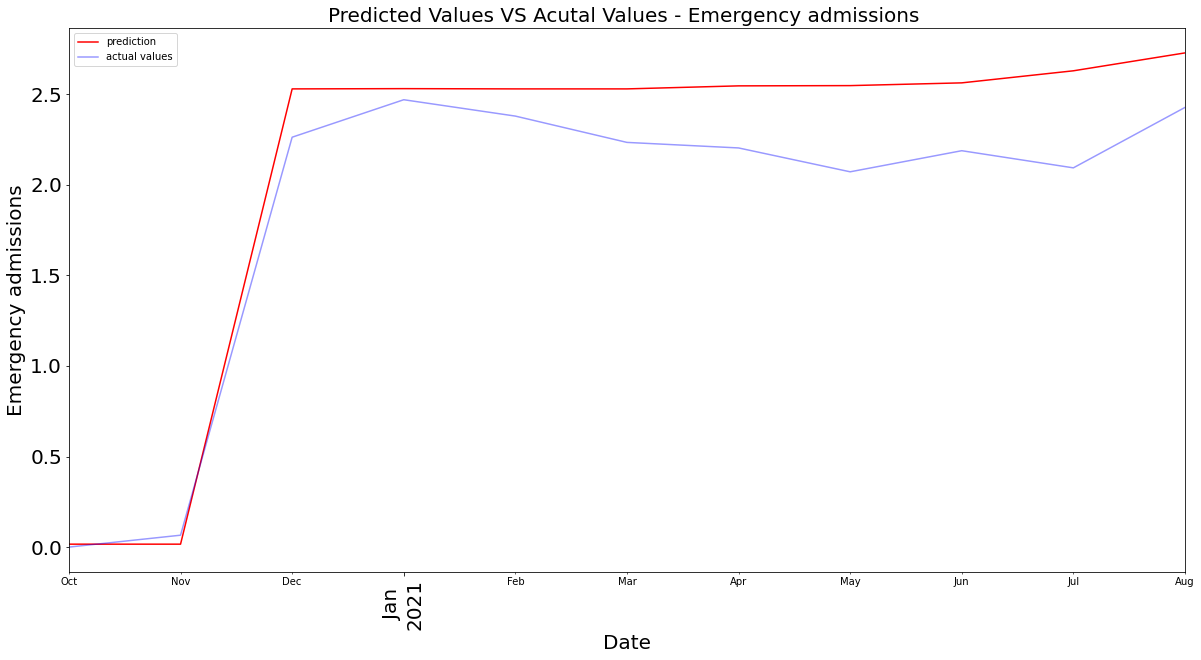

In [26]:
plt.figure(figsize=(20,10))
pa.groupby('Month_Ending')['Prediction'].sum().plot(kind='line',label='prediction',color='red',alpha=1)
pa.groupby("Month_Ending")['Actual Values'].sum().plot(kind='line',label='actual values',color='blue',alpha=0.4)
plt.xticks(rotation=90,size=20)
plt.yticks(size=20)

plt.ylabel('Emergency admissions',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.title('Predicted Values VS Acutal Values - Emergency admissions ',fontsize=20)
plt.legend()

In [ ]:
#def RMSE(actual,prediction):
  #  rmse = np.sqrt(mean_squared_error(actual,prediction))
   # return rmse

In [ ]:
#print(RMSE(y_test[:-1],[i[0] for i in y_test_pre][1:]))